In [85]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
SEED = 8
random.seed(SEED)
np.random.seed(SEED)


In [86]:
stocks = ['A', 'GS']
start_date = "2019-01-01"
end_date = "2024-05-01"
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()


[*********************100%%**********************]  2 of 2 completed


,A,GS
Date,,
2019-01-02,63.278915,150.765137
2019-01-03,60.947735,148.556610
2019-01-04,63.057354,153.411835
2019-01-07,64.396332,154.261917
2019-01-08,65.340355,153.692291


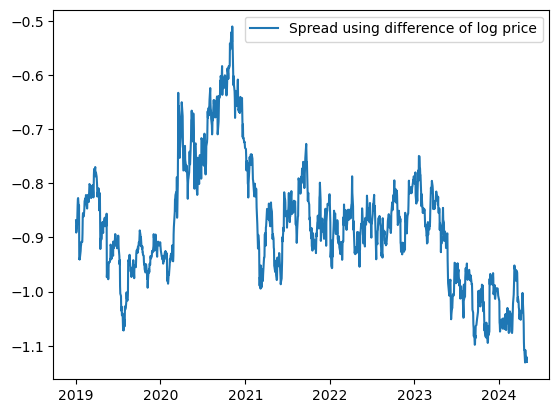

In [87]:
spread = np.log(df[stocks[0]]) - np.log(df[stocks[1]])
plt.plot(spread, label='Spread using difference of log price')
plt.legend()
plt.show()

asset1_returns = np.log(df[stocks[0]]).diff()
asset2_returns = np.log(df[stocks[1]]).diff()
spread_ma5 = spread.rolling(5).mean()
asset1_volatility = asset1_returns.rolling(20).std()
asset2_volatility = asset2_returns.rolling(20).std()

X = pd.DataFrame({'Asset1Returns': asset1_returns,
                  'Asset2Returns': asset2_returns,
                  'SpreadMA5': spread_ma5,
                  'Asset1Volatility': asset1_volatility,
                  'Asset2Volatility': asset2_volatility})
X = X.fillna(0)
y = spread


In [88]:
# split train/test set
train_size = int(len(spread) * 0.92)
train_X = X[:train_size]
test_X = X[train_size:]
train_y = y[:train_size]
test_y = y[train_size:]


In [89]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# use SVR to predict
svm_model = SVR(kernel='linear')
svm_model.fit(train_X, train_y)
train_pred = svm_model.predict(train_X)
print("Training RMSE: ", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = svm_model.predict(test_X)
print("Test RMSE: ", np.sqrt(mean_squared_error(test_y, test_pred)))


Training RMSE:  0.053555980300882
Test RMSE:  0.07479035473008525


In [90]:
def score_fn(model, type="non_neural_net"):
    if type == "non_neural_net":
        test_pred = model.predict(test_X)
    else:
        test_pred = model(torch.Tensor(test_X.values)).detach().numpy()
    
    zscore = (spread[train_size:] - test_pred.mean()) / test_pred.std()
    entry_threshold = 2.0
    exit_threshold = 1.0
    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)
    
    for i in range(1, len(zscore)):
        if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
            stock1_position[i] = 1
            stock2_position[i] = -1
        elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
            stock1_position[i] = -1
            stock2_position[i] = 1
        elif abs(zscore[i]) < exit_threshold:
            stock1_position[i] = 0
            stock2_position[i] = 0
        else:
            stock1_position[i] = stock1_position[i-1]
            stock2_position[i] = stock2_position[i-1]
    
    stock1_returns = (test_X['Asset1Returns'] * stock1_position.shift(1)).fillna(0)
    stock2_returns = (test_X['Asset2Returns'] * stock2_position.shift(1)).fillna(0)
    total_returns = stock1_returns + stock2_returns
    cumulative_returns = (1 + total_returns).cumprod()
    return cumulative_returns, total_returns

# evaluate pnl
cumulative_returns, pnl = score_fn(svm_model)


In [91]:
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    sharpe = pnl.mean() / pnl.std()
    sharpe = sharpe * np.sqrt(252)
    print("")
    print("PERFORMANCE STATISTICS FOR " + label)
    print("Daily annualized sharpe: " + str(sharpe))
    print("Average annual returns: " + str(pnl.mean() * 252 * 100) + "%")
    print("Total returns: " + str(pnl.sum() * 100) + "%")
    highwatermark_df = cumpnl.cummax()
    drawdown_df = cumpnl - highwatermark_df
    maxdrawdown = drawdown_df.min()
    print("Max drawdown: " + str(maxdrawdown * 100) + "%")
    plt.plot(cumpnl.values, label=label)
    plt.legend()
    plt.title("Cumulative PNL chart")
    plt.show()

Training RMSE:  0.00643527992799419
Test RMSE:  0.01990585084086875

PERFORMANCE STATISTICS FOR MARKET NEUTRAL Random Forest
Daily annualized sharpe: 1.1439959055785625
Average annual returns: 10.295823477716375%
Total returns: 4.41249577616416%
Max drawdown: -2.3677529341131986%


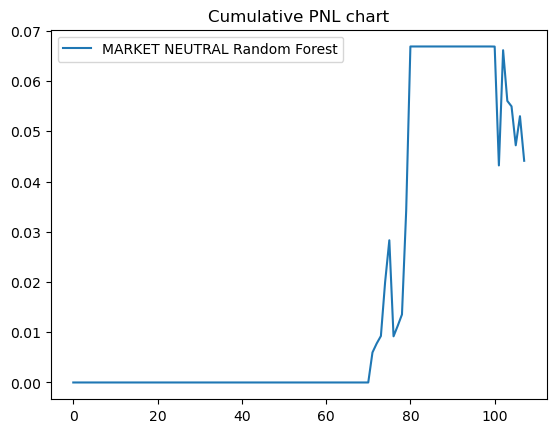

Epoch 0, Loss: 0.5938
Epoch 10, Loss: 0.3422
Epoch 20, Loss: 0.1306
Epoch 30, Loss: 0.0178
Epoch 40, Loss: 0.0101
Epoch 50, Loss: 0.0114
Epoch 60, Loss: 0.0056
Epoch 70, Loss: 0.0057
Epoch 80, Loss: 0.0047
Epoch 90, Loss: 0.0043
Training RMSE:  0.061794266
Test RMSE:  0.08426298

PERFORMANCE STATISTICS FOR MARKET NEUTRAL Neural Network
Daily annualized sharpe: -0.6610800038426795
Average annual returns: -13.571167616789442%
Total returns: -5.81621469290976%
Max drawdown: -12.834631347384828%


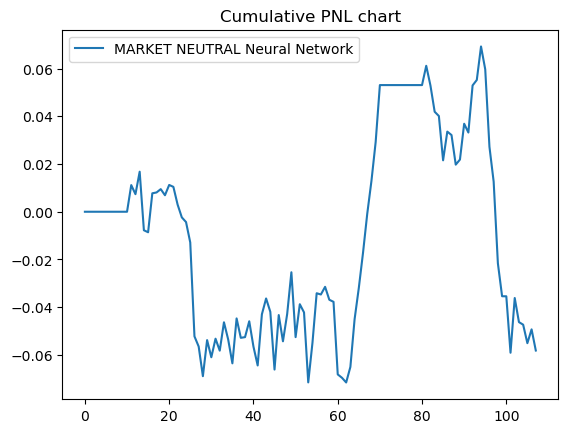

In [96]:
# random forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_X, train_y)
train_pred = rf_model.predict(train_X)
print("Training RMSE: ", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = rf_model.predict(test_X)
print("Test RMSE: ", np.sqrt(mean_squared_error(test_y, test_pred)))
cumulative_returns, pnl = score_fn(rf_model)
pnlPerformance(pnl, "MARKET NEUTRAL Random Forest")

# neural network
import torch
import torch.nn as nn
import torch.optim as optim

train_X_ts = torch.Tensor(train_X.values)
train_y_ts = torch.Tensor(train_y.values).view(-1, 1)
test_X_ts = torch.Tensor(test_X.values)
test_y_ts = torch.Tensor(test_y.values).view(-1, 1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

nn_model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = nn_model(train_X_ts)
    loss = criterion(outputs, train_y_ts)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print("Epoch {}, Loss: {:.4f}".format(epoch, loss.item()))

train_pred = nn_model(train_X_ts).detach().numpy()
print("Training RMSE: ", np.sqrt(mean_squared_error(train_y_ts, train_pred)))
test_pred = nn_model(test_X_ts).detach().numpy()
print("Test RMSE: ", np.sqrt(mean_squared_error(test_y_ts, test_pred)))
cumulative_returns, pnl = score_fn(nn_model, type="nn")
pnlPerformance(pnl, "MARKET NEUTRAL Neural Network")

Best Entry Threshold: 0.5, Best Exit Threshold: 2.6, Max Return: 0.1755655336164379

PERFORMANCE STATISTICS FOR MARKET NEUTRAL XGBoost
Daily annualized sharpe: 3.0387566596808555
Average annual returns: 40.96529117716884%
Total returns: 17.55655336164379%
Max drawdown: -4.425988997484875%


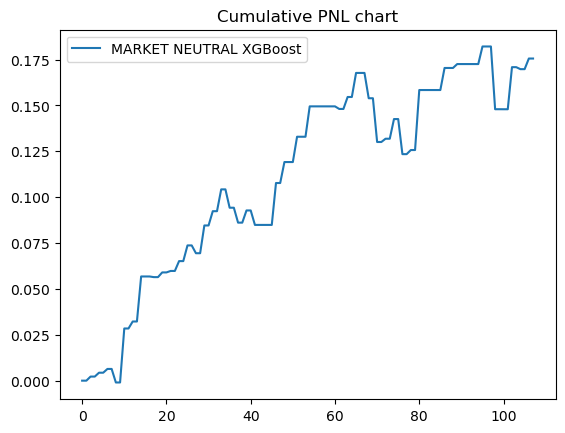

Best Parameters: {'C': 100, 'epsilon': 0.01, 'entry_threshold': 0.5, 'exit_threshold': 0.1}, Max Return: 0.22642000370397497

PERFORMANCE STATISTICS FOR MARKET NEUTRAL SVM with Optimal Parameters
Daily annualized sharpe: 2.498649174145456
Average annual returns: 52.83133419759416%
Total returns: 22.642000370397497%
Max drawdown: -7.805155868428759%


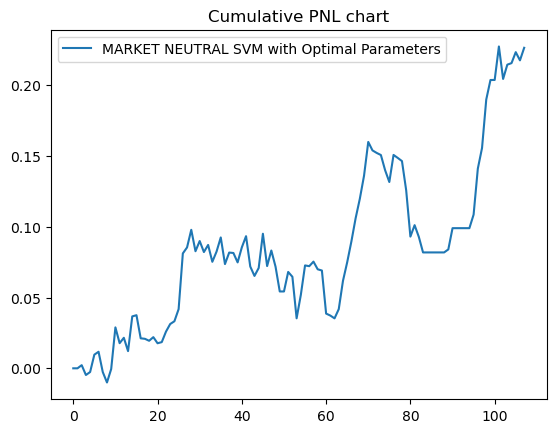

In [101]:
from sklearn.metrics import mean_squared_error

# Define the expanded range of parameters for grid search
entry_thresholds = np.arange(0.5, 5.0, 0.5)
exit_thresholds = np.arange(0.1, 3.0, 0.5)
C_values = [0.1, 1, 10, 100]
epsilon_values = [0.01, 0.1, 0.2, 0.5]


# Initialize variables to store the best parameters and maximum return
best_entry_threshold = None
best_exit_threshold = None
max_return = -np.inf

# Grid search
for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        _, pnl = score_fn(xgb_model, type="non_neural_net", entry_threshold=entry_threshold, exit_threshold=exit_threshold)
        total_return = pnl.sum()
        if total_return > max_return:
            max_return = total_return
            best_entry_threshold = entry_threshold
            best_exit_threshold = exit_threshold

print(f"Best Entry Threshold: {best_entry_threshold}, Best Exit Threshold: {best_exit_threshold}, Max Return: {max_return}")

# Perform final evaluation using the best thresholds
cumulative_returns, pnl = score_fn(xgb_model, type="non_neural_net", entry_threshold=best_entry_threshold, exit_threshold=best_exit_threshold)
pnlPerformance(pnl, "MARKET NEUTRAL XGBoost")

# Initialize variables to store the best parameters and maximum return
best_params = {'C': None, 'epsilon': None, 'entry_threshold': None, 'exit_threshold': None}
max_return = -np.inf

# Grid search
for C in C_values:
    for epsilon in epsilon_values:
        svm_model = SVR(kernel='rbf', C=C, epsilon=epsilon)
        svm_model.fit(train_X, train_y)
        
        for entry_threshold in entry_thresholds:
            for exit_threshold in exit_thresholds:
                _, pnl = score_fn(svm_model, type="non_neural_net", entry_threshold=entry_threshold, exit_threshold=exit_threshold)
                total_return = pnl.sum()
                if total_return > max_return:
                    max_return = total_return
                    best_params['C'] = C
                    best_params['epsilon'] = epsilon
                    best_params['entry_threshold'] = entry_threshold
                    best_params['exit_threshold'] = exit_threshold

print(f"Best Parameters: {best_params}, Max Return: {max_return}")

# Perform final evaluation using the best parameters
svm_model = SVR(kernel='rbf', C=best_params['C'], epsilon=best_params['epsilon'])
svm_model.fit(train_X, train_y)
cumulative_returns, pnl = score_fn(svm_model, type="non_neural_net", entry_threshold=best_params['entry_threshold'], exit_threshold=best_params['exit_threshold'])
pnlPerformance(pnl, "MARKET NEUTRAL SVM")
